In [156]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math
import random
import numpy as np
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization

%matplotlib notebook

print('cusa available: ', torch.cuda.is_available())

# use either cpu or gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
device = "cpu"

# function 1 ::  SUM( x )
def f_1(x):
    return torch.FloatTensor([sum(x)]).to(device)

# function 2 ::  SUM( 3*x^2 + 2*x )
def f_2(x):
    res = 0.0
    for xi in x:
        res += 2*xi + 3*pow(xi, 2)
    return torch.FloatTensor([res]).to(device)

a = [10*random.random() for _ in range(10)]
e = [[random.randint(0, 3) for _ in range(20)] for _ in range(10)]

# function 3 :: random polynomial w 10 monomials and max exponents of 3
def f_3(x):
    res = 0.0
    # a = [10*random.random() for _ in range(10)]
    # e = [[random.randint(0, 6) for _ in range(len(x))] for _ in range(10)]
    for ei, ai in zip(e, a):
        res += ai*sum([pow(xi, elem) for elem, xi in zip(ei, x)])
    return torch.FloatTensor([res]).to(device)

# nn builder class
class Net(nn.Module):

    def __init__(self, input_size, mon_size, out_size):
        super(Net, self).__init__()
        # input should be of size input_size, output mon_size. trained weights=e_nm
        self.lin_hidden = nn.Linear(input_size, mon_size, bias=False)
        self.lin_hidden.weight.data.uniform_(0.0, 1.0/input_size)
        # output lin layer, trained weights=a_m
        self.lin_output = nn.Linear(mon_size, out_size, bias=False)
        self.lin_output.weight.data.uniform_(0.0, 1.0/input_size)

    def forward(self, x):
        # x = exp_activation(self.lin_hidden(log_activation(x)))
        x = torch.exp(self.lin_hidden(torch.log(x)))
        x = self.lin_output(x)
        return x
    
# function dictionary
funcs = [f_1, f_2, f_3]
cutoffs = [0.6, 0.4, 0.2]

print('constants f3: ', a)
print('exponents f3: ', e)

cusa available:  True
cuda:0
constants f3:  [8.830186572767516, 4.35990356925061, 2.858858861732073, 5.736434044681738, 3.8134485912311344, 7.322903587122386, 0.0785797909549657, 9.475757183073759, 3.3431632662211586, 0.626841605161973]
exponents f3:  [[2, 1, 1, 0, 1, 3, 1, 1, 3, 0, 2, 3, 1, 2, 1, 0, 2, 3, 0, 3], [0, 2, 1, 2, 0, 1, 3, 0, 1, 2, 0, 2, 0, 1, 3, 1, 1, 0, 3, 0], [1, 2, 3, 2, 3, 0, 2, 0, 1, 0, 2, 3, 1, 1, 2, 3, 1, 3, 2, 1], [1, 0, 1, 2, 0, 1, 2, 0, 3, 3, 0, 2, 1, 3, 3, 2, 0, 3, 0, 2], [0, 3, 2, 0, 2, 0, 1, 1, 0, 2, 2, 2, 1, 0, 1, 0, 0, 3, 2, 1], [2, 0, 3, 1, 3, 1, 0, 1, 0, 1, 1, 2, 1, 0, 0, 1, 0, 3, 0, 3], [0, 3, 0, 0, 2, 2, 1, 3, 2, 0, 3, 0, 1, 1, 2, 0, 3, 2, 3, 2], [0, 3, 2, 2, 1, 0, 2, 2, 3, 2, 3, 3, 1, 1, 3, 0, 3, 1, 2, 0], [1, 2, 2, 3, 3, 0, 2, 2, 2, 0, 0, 3, 3, 2, 2, 2, 0, 1, 1, 1], [3, 3, 3, 1, 3, 2, 3, 3, 3, 0, 2, 2, 2, 3, 2, 3, 3, 2, 0, 1]]


In [63]:
# generate synthetic dataset
def make_data(n, f_num=0):
    X = []
    y = []
    f = funcs[f_num]
    c = cutoffs[f_num]
    for i in range(n):  # 10000):
        noise = 0
        while noise == 0:
            noise = random.random()
        inputs = [10*random.random()*noise for _ in range(20)]
        inputs = [1 if ip == 0 else ip for ip in inputs]
        # while sum_func_2(inputs) > sum_func_2([10 for _ in range(20)])*0.4:  # sum(inputs) > 100:
        while f(inputs) > f([10 for _ in range(20)])*c:
            inputs = [10*random.random()*noise for _ in range(20)]
            inputs = [1 if ip == 0 else ip for ip in inputs]
        X.append(inputs) 
        y.append([f(inputs)])
    return torch.FloatTensor(X).to(device), torch.FloatTensor(y).to(device)

'''
# pytorch data loader with
def data_loader(data, bs=32, s=True)
    return DataLoader(data, batch_size=bs, shuffle=s)
'''

'\n# pytorch data loader with\ndef data_loader(data, bs=32, s=True)\n    return DataLoader(data, batch_size=bs, shuffle=s)\n'

In [179]:
inf = float('inf')

# do train test split
# define train and evaluate method
# cross validation
# training
# take method

def train_and_test(X, y, input_vars, monomials, bs, s, lr, m, max_epochs=20, clip_norm=2.0, nsplits=8):
    # X, y = make_data(n, f_num)
    kf = KFold(n_splits=nsplits)
    val_losses = 0
    rand_losses = 0
    for j, indices in enumerate(kf.split(X)):
        print('\n============= split '+str(j+1)+' =============\n')
        train_index, test_index = indices
        # print(type(train_index), type(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        prev_loss = inf
        net = Net(input_vars, monomials, 1)
        criterion = nn.L1Loss()
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=m)
        training_data = DataLoader(list(zip(X_train, y_train)), batch_size=bs, shuffle=s)
        runing_loss = 0.0
        for epoch in range(max_epochs):  # loop over the dataset multiple times
            running_loss = 0.0
            for i, data in enumerate(training_data):
                # get the inputs; data is a list of [inputs, labels]
                inputs, result = data
                # print(inputs)
                # print(result)
                # break
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, result)
                loss.backward()
                nn.utils.clip_grad_norm_(net.parameters(), max_norm=clip_norm)
                optimizer.step()
                # print statistics
                running_loss += loss.item()
                '''
                if i % 100 == 99:    # print every 2000 mini-batches
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 100))
                    r_loss += running_loss
                    running_loss = 0.0
                '''
            print('epoch: ', epoch, '; loss: ', running_loss/len(training_data))
            # if (running_loss/prev_loss) > 0.99:
            if running_loss > prev_loss:
                break
            prev_loss = running_loss
        # validation set
        out = net(X_test)
        loss = criterion(out, y_test)
        print('\nvalidation loss: ', loss.item())
        vals = [[int(dat[0])] for dat in y_train]
        random.shuffle(vals)
        vals = torch.FloatTensor(vals[:len(y_test)]).to(device)
        rand_loss = criterion(vals, y_test)
        print('\nrandom guess loss: ', rand_loss.item())
        val_losses += loss.item()
        rand_losses += rand_loss.item()
    print('\n\n--------------\n\n')
    print('average loss: ', val_losses/nsplits)
    print('average rand loss: ', rand_losses/nsplits)
    


In [186]:
X, y = make_data(n=64*800, f_num=2)

<IPython.core.display.Javascript object>


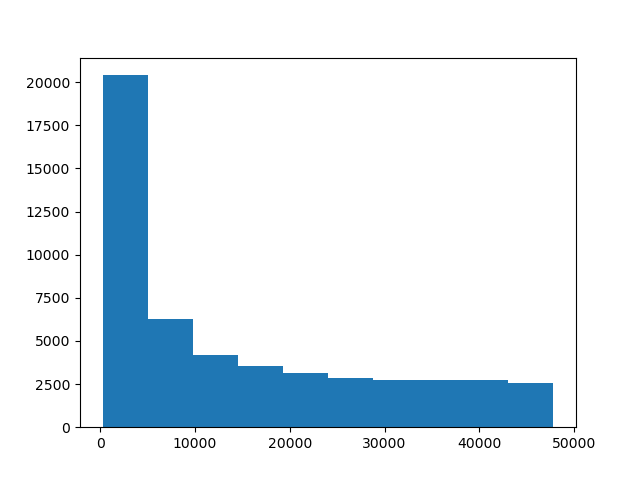

(array([20407.,  6280.,  4199.,  3545.,  3137.,  2834.,  2753.,  2750.,
         2731.,  2564.]),
 array([  239. ,  4997.5,  9756. , 14514.5, 19273. , 24031.5, 28790. ,
        33548.5, 38307. , 43065.5, 47824. ]),
 <BarContainer object of 10 artists>)

In [187]:
%matplotlib notebook
vals = [int(dat[0]) for dat in y]  # for _, dat in train_data]
plt.hist(vals)

In [189]:
train_and_test(X, y, input_vars=20, monomials=24, bs=32, s=True, lr=0.004, m=0.8, max_epochs=160, clip_norm=2.0, nsplits=5)


============= split 1 =============

epoch:  0 ; loss:  12108.916262817384
epoch:  1 ; loss:  11609.181366348266
epoch:  2 ; loss:  11479.06781692505
epoch:  3 ; loss:  11360.718015670776
epoch:  4 ; loss:  10916.152074432373
epoch:  5 ; loss:  10153.590438079835
epoch:  6 ; loss:  9657.957400512696
epoch:  7 ; loss:  9042.597157287597
epoch:  8 ; loss:  8563.206969642639
epoch:  9 ; loss:  8045.078337097168
epoch:  10 ; loss:  7648.788803672791
epoch:  11 ; loss:  7273.638795661926
epoch:  12 ; loss:  6954.910645103455
epoch:  13 ; loss:  6699.44117565155
epoch:  14 ; loss:  6487.613308525086
epoch:  15 ; loss:  6285.451289367676
epoch:  16 ; loss:  6094.988608551025
epoch:  17 ; loss:  5882.179535102844
epoch:  18 ; loss:  5681.265370178223
epoch:  19 ; loss:  5463.881785774231
epoch:  20 ; loss:  5232.345993232727
epoch:  21 ; loss:  5007.468152999878
epoch:  22 ; loss:  4869.149189949036
epoch:  23 ; loss:  4764.761113357544
epoch:  24 ; loss:  4651.417823982239
epoch:  25 ; loss:

epoch:  112 ; loss:  1660.8435473918914
epoch:  113 ; loss:  1651.72394695282
epoch:  114 ; loss:  1641.9630915641785
epoch:  115 ; loss:  1627.3862580776215
epoch:  116 ; loss:  1623.9225260734559
epoch:  117 ; loss:  1615.9641053199769
epoch:  118 ; loss:  1611.724828338623
epoch:  119 ; loss:  1599.237716770172
epoch:  120 ; loss:  1587.6283499240876
epoch:  121 ; loss:  1580.6543452739716
epoch:  122 ; loss:  1578.092315530777
epoch:  123 ; loss:  1568.3662691116333
epoch:  124 ; loss:  1567.6798411369323
epoch:  125 ; loss:  1554.3849977970124
epoch:  126 ; loss:  1550.8175566196442
epoch:  127 ; loss:  1545.210459089279
epoch:  128 ; loss:  1537.1010751724243
epoch:  129 ; loss:  1524.6782050132751
epoch:  130 ; loss:  1520.6748277187348
epoch:  131 ; loss:  1515.5098612308502
epoch:  132 ; loss:  1506.8044118881226
epoch:  133 ; loss:  1500.3579315185548
epoch:  134 ; loss:  1497.33958568573
epoch:  135 ; loss:  1484.9780379772187
epoch:  136 ; loss:  1475.5642865180969
epoch:  

epoch:  0 ; loss:  12147.543983459473
epoch:  1 ; loss:  11339.333835220337
epoch:  2 ; loss:  10655.228610992432
epoch:  3 ; loss:  10453.185396575927
epoch:  4 ; loss:  10088.072320175172
epoch:  5 ; loss:  9585.559823608399
epoch:  6 ; loss:  9219.063084793092
epoch:  7 ; loss:  8812.81318321228
epoch:  8 ; loss:  8486.402970504761
epoch:  9 ; loss:  8170.409092140198
epoch:  10 ; loss:  7833.553388595581
epoch:  11 ; loss:  7514.453872489929
epoch:  12 ; loss:  7235.198852729797
epoch:  13 ; loss:  6983.739813995361
epoch:  14 ; loss:  6772.457427406311
epoch:  15 ; loss:  6615.819473648071
epoch:  16 ; loss:  6419.324576950074
epoch:  17 ; loss:  6236.66932811737
epoch:  18 ; loss:  6052.61403388977
epoch:  19 ; loss:  5907.292632102966
epoch:  20 ; loss:  5726.083768081665
epoch:  21 ; loss:  5570.7180240631105
epoch:  22 ; loss:  5399.860479545593
epoch:  23 ; loss:  5214.712587738037
epoch:  24 ; loss:  4980.208292007446
epoch:  25 ; loss:  4689.866409301758
epoch:  26 ; loss: 

epoch:  55 ; loss:  2917.833637046814
epoch:  56 ; loss:  2878.12930059433
epoch:  57 ; loss:  2852.2871483802796
epoch:  58 ; loss:  2811.593845939636
epoch:  59 ; loss:  2781.3086099624634
epoch:  60 ; loss:  2746.769966030121
epoch:  61 ; loss:  2708.689231681824
epoch:  62 ; loss:  2686.4449955940245
epoch:  63 ; loss:  2663.233614730835
epoch:  64 ; loss:  2629.9020157814025
epoch:  65 ; loss:  2608.5042147636414
epoch:  66 ; loss:  2583.861003780365
epoch:  67 ; loss:  2558.1522453308107
epoch:  68 ; loss:  2536.204440021515
epoch:  69 ; loss:  2516.3590987205507
epoch:  70 ; loss:  2491.216888713837
epoch:  71 ; loss:  2474.0514154434204
epoch:  72 ; loss:  2449.104946231842
epoch:  73 ; loss:  2420.4041669845583
epoch:  74 ; loss:  2405.47505979538
epoch:  75 ; loss:  2386.554192638397
epoch:  76 ; loss:  2363.009173107147
epoch:  77 ; loss:  2332.877448749542
epoch:  78 ; loss:  2318.045158290863
epoch:  79 ; loss:  2309.689113044739
epoch:  80 ; loss:  2287.419486618042
epoch